In [3]:
import os
import cv2 as cv
from PIL import Image
import numpy as np
import pickle
from tqdm import tqdm
import torchvision.transforms as transforms
#CV2  4.1.2可以用绝对地址，新版本只能使用相对路径
data_dir = 'data/CUB_200_2011'
dataset_train = "train.csv"
dataset_val = "val.csv"
dataset_test = "test.csv"
normalize = transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])

In [4]:
"""读取 CSV文件，以字典类型返回每一列的内容。"""
def read_csv_labels(fname):
    with open(fname, 'r') as f:
        # 跳过文件头行 (列名)
        lines = f.readlines()[1:]
    tokens = [row.rstrip().split(',') for row in lines]
    #return dict(((name, label) for name, label in tokens))
    fname = []
    flabel = []
    for name, label in tokens:
        fname.append(name)
        flabel.append(label)
    csv_dic = {'col_filename': fname, 'col_label' : flabel}
    return  csv_dic

In [5]:
train_data = read_csv_labels(os.path.join(data_dir, dataset_train))
val_data = read_csv_labels(os.path.join(data_dir, dataset_val))
test_data = read_csv_labels(os.path.join(data_dir, dataset_test))
print(train_data['col_filename'][0],train_data['col_label'][0])
print('image_number:',len(train_data['col_label']),len(val_data['col_label']),len(test_data['col_label']))

CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0033_796086.jpg 0
image_number: 5885 2950 2953


In [6]:
#求类别，并合并label
labels_train_set = set(train_data['col_label'])
labels_val_set = set(val_data['col_label'])
labels_test_set = set(test_data['col_label'])

print('[train_labels]=',list(labels_train_set),len(list(labels_train_set)))
print('%s类别数:' %dataset_train,len(labels_train_set))
print('%s类别数:' %dataset_val,len(labels_val_set))
print('%s类别数:' %dataset_test,len(labels_test_set))

print('train,val交集： ',labels_train_set & labels_val_set)
print('train,test交集： ',labels_train_set & labels_test_set)
print('val,test交集： ',labels_val_set & labels_test_set)

labels_list = list(labels_train_set) + list(labels_val_set) + list(labels_test_set)
print('数据集label总数：',len(labels_list))

[train_labels]= ['100', '122', '42', '146', '186', '138', '46', '2', '154', '72', '92', '164', '40', '128', '24', '28', '160', '104', '76', '10', '178', '194', '48', '82', '148', '102', '130', '184', '20', '174', '34', '60', '74', '52', '156', '38', '170', '70', '22', '192', '18', '94', '12', '132', '118', '116', '84', '108', '196', '136', '16', '58', '162', '114', '32', '62', '134', '50', '86', '96', '66', '180', '126', '172', '168', '112', '198', '26', '188', '90', '56', '142', '4', '110', '144', '98', '190', '44', '166', '80', '150', '182', '0', '64', '176', '78', '14', '68', '88', '106', '8', '54', '140', '6', '120', '158', '30', '36', '124', '152'] 100
train.csv类别数: 100
val.csv类别数: 50
test.csv类别数: 50
train,val交集：  set()
train,test交集：  set()
val,test交集：  set()
数据集label总数： 200


In [7]:
#将类别转化为数字标号
labels_dict = {}
i = 1
for l in labels_list:
    if l not in labels_dict:
        labels_dict[l] = i
        i = i+1
print(labels_dict)

{'100': 1, '122': 2, '42': 3, '146': 4, '186': 5, '138': 6, '46': 7, '2': 8, '154': 9, '72': 10, '92': 11, '164': 12, '40': 13, '128': 14, '24': 15, '28': 16, '160': 17, '104': 18, '76': 19, '10': 20, '178': 21, '194': 22, '48': 23, '82': 24, '148': 25, '102': 26, '130': 27, '184': 28, '20': 29, '174': 30, '34': 31, '60': 32, '74': 33, '52': 34, '156': 35, '38': 36, '170': 37, '70': 38, '22': 39, '192': 40, '18': 41, '94': 42, '12': 43, '132': 44, '118': 45, '116': 46, '84': 47, '108': 48, '196': 49, '136': 50, '16': 51, '58': 52, '162': 53, '114': 54, '32': 55, '62': 56, '134': 57, '50': 58, '86': 59, '96': 60, '66': 61, '180': 62, '126': 63, '172': 64, '168': 65, '112': 66, '198': 67, '26': 68, '188': 69, '90': 70, '56': 71, '142': 72, '4': 73, '110': 74, '144': 75, '98': 76, '190': 77, '44': 78, '166': 79, '80': 80, '150': 81, '182': 82, '0': 83, '64': 84, '176': 85, '78': 86, '14': 87, '68': 88, '88': 89, '106': 90, '8': 91, '54': 92, '140': 93, '6': 94, '120': 95, '158': 96, '30':

In [12]:
fname = train_data['col_filename'][0]
fall_path = os.path.join(data_dir, fname)
image = cv.imread(fall_path)#读取图片
image = Image.open(fall_path)
image.show()

In [6]:
"""
读取图像文件，存入list中
下面直接封装成  get_image(path,_data)函数
"""
images = []
labels = []
i = 0
with tqdm(total=len(train_data['col_filename'])) as pbar:
    pbar.set_description('Processing:')
    for fname,flabel in zip(train_data['col_filename'],train_data['col_label']):
        fall_path = os.path.join(data_dir, fname)
        image = cv.imread(fall_path)#读取图片
        #image = Image.open(fall_path)
        images.append(image)#存入数组
        labels.append(labels_dict[flabel])#存入数组
        pbar.update(1)#更新进度条
        i+=1
        #if i==3:
         #   img0=Image.open(fall_path)
          #  img0.show()
        if i==2:
            cv.imshow("image",image)
            cv.waitKey(0)
print(len(images))
print(os.path.join(data_dir, 'images', train_data['col_filename'][0]))
print(set(labels))

Processing:: 100%|██████████| 5885/5885 [01:29<00:00, 65.95it/s]

5885
data/CUB_200_2011/images/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0033_796086.jpg
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100}


In [14]:
print(images[0].shape,labels[0])
#cv.imshow("image label: %s" %labels[0],images[0])

#cv.waitKey(0)

(375, 500, 3) 0


In [8]:
#对应图像小于crop高宽的,筛选出来
def filter(imgs,crop_size):
    return [img for img in imgs if (
        img.shape[0] < crop_size[0] or img.shape[1] < crop_size[1])]

In [2]:
small_image = filter(images,[84,84])
print('小图片数量：',len(small_image))
if(len(small_image)>0):
    print(small_image[1].shape)
    Image.fromarray(small_image[1]).show()
    Image.fromarray(cv.resize(small_image[1],(84,84))).show()

NameError: name 'images' is not defined

In [9]:
"""
读取图像文件，存入list中
"""
def get_image(path,_data):
    images = []
    labels = []
    crop_size = [84,84]
    with tqdm(total=len(_data['col_filename'])) as pbar:
        pbar.set_description('Getting image processing:')
        for fname,flabel in zip(_data['col_filename'],_data['col_label']):
            fall_path = os.path.join(path, fname)
            image = cv.imread(fall_path)
            #if(image.shape[0] < crop_size[0] or image.shape[1] < crop_size[1]):
             #   image = cv.resize(image,(84,84))#resize成（84，84）满足后续crop的需要
            image = cv.resize(image,(84,84))#resize成（84，84）
            images.append(image)
            labels.append(labels_dict[flabel])
            pbar.update(1)#更新进度条
    return images, labels

In [26]:
"""
写入.pickle文件
"""
images, labels = get_image(data_dir,test_data)#替换上面读取的csv数据
images = np.asarray(images,dtype=object)
print(images.shape)
small_image = filter(images,[84,84])
print('小图片数量：',len(small_image))
train_dic = {'data': images, 'labels' : labels}
#train.csv  CUB_200_2011_category_split_train_phase_train.pickle
#val.csv  CUB_200_2011_category_split_train_phase_val.pickle
#test.csv  CUB_200_2011_category_split_test.pickle
with open('CUB_200_2011_category_split_test.pickle', 'wb') as f:
    pickle.dump(train_dic, f)
    f.close()

Getting image processing:: 100%|██████████| 2953/2953 [00:42<00:00, 69.77it/s]


(2953, 84, 84, 3)
小图片数量： 0


In [19]:
'''
#测试--写pickle文件
a = 'owoof'
with open('111.pkl', 'wb') as file:
    pickle.dump(a, file)
'''

小图片数量： 0


In [11]:
import matplotlib.pyplot as plt

In [27]:
"""
读取.pickle文件
"""
#path='CUB_200_2011_category_split_train_phase_train.pickle'
#path='CUB_200_2011_category_split_train_phase_val.pickle'
path='CUB_200_2011_category_split_test.pickle'
with open(path,'rb') as f:
    data = pickle.load(f, encoding='bytes')
    imgs = data['data']
    labels = data['labels']
print(len(imgs))
print(imgs[0].shape)

2953
(84, 84, 3)


[174, 174, 174, 174, 174, 174, 174, 174, 174, 174]


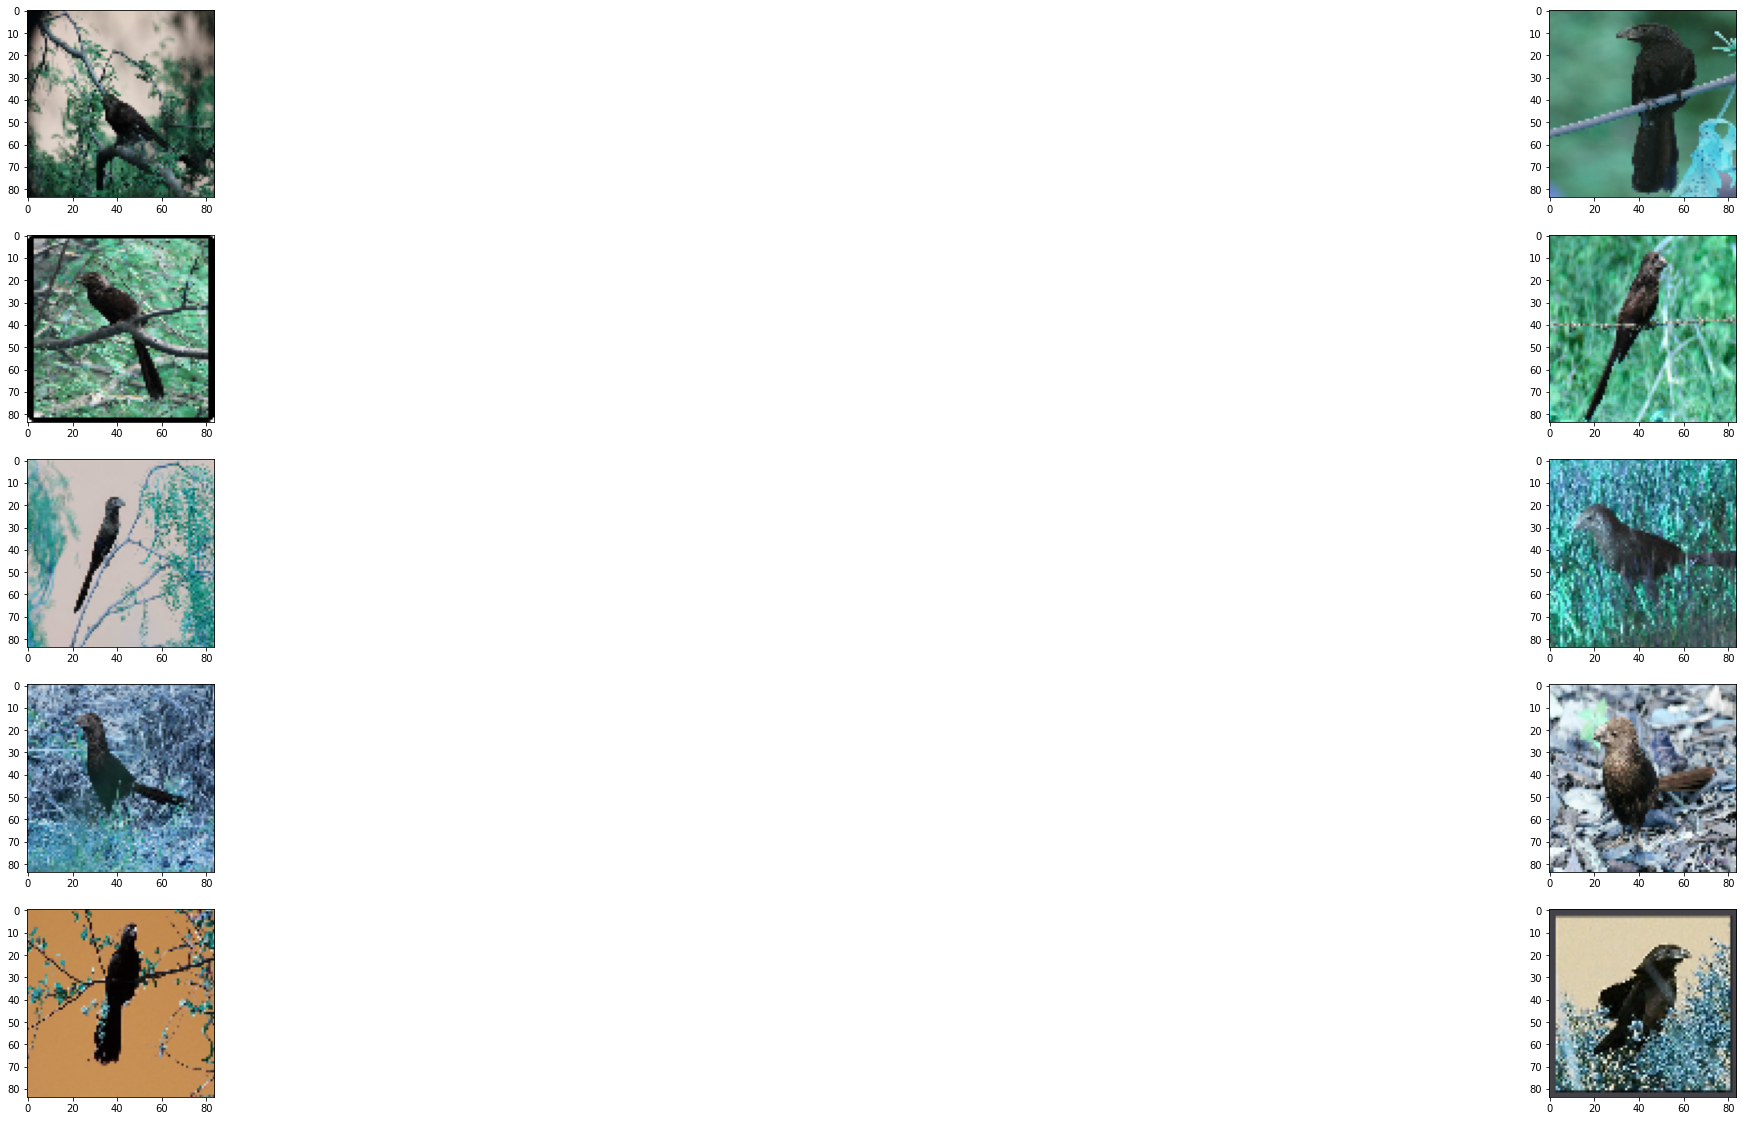

In [28]:
#测试生成的数据正确不
def test(train_dataset,train_label):
    print(train_label[:10])
    plt.figure(figsize=(50,20))
    for i in range(10):
        plt.subplot(5,2,i+1)
        plt.imshow(np.asarray(train_dataset[i]).astype('uint8'))
    plt.show()
    
test(imgs,labels)

In [14]:
item = 0
img = np.asarray(imgs[item]).astype('uint8')
img = Image.fromarray(img)
img.show()

In [29]:
slabels = np.asarray(labels)
print(slabels)
np.min(slabels)
slabels = slabels - np.min(slabels)
numclass = np.max(slabels)+1
print('number of class=',numclass)

[174 174 174 ... 154 154 154]
number of class= 50


In [19]:
transform_A = [
    transforms.Compose([
        lambda x: Image.fromarray(x),
        transforms.RandomCrop(84, padding=8),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.RandomHorizontalFlip(),
        lambda x: np.asarray(x),
        transforms.ToTensor(),
        normalize
    ]),

    transforms.Compose([
        lambda x: Image.fromarray(x),
        transforms.ToTensor(),
        normalize
    ])

]

In [20]:
item = 1
img = np.asarray(imgs[item]).astype('uint8')
print(img.shape)
train_trans, test_trans = transform_A
img = test_trans(img)
print(img.shape)

(84, 84, 3)
torch.Size([3, 84, 84])
